In [47]:
import tensorflow as tf
from tensorflow.keras import layers, models , initializers
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os


In [48]:
def load_images_from_dir(directory, target_size=(320, 320)):
    image_list = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(directory, filename)
            # Load the image using OpenCV
            image = cv2.imread(image_path)
            if image is None:
                print(f"Warning: Unable to load image '{filename}'")
                continue
            
            # Convert BGR to RGB format
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Resize the image
            resized_image = cv2.resize(image_rgb, target_size)
            image_list.append(resized_image)
    return image_list



In [49]:
directory_path = "data/monet_jpg/"
monet_image_list = load_images_from_dir(directory_path)
print("Number of images loaded:", len(monet_image_list))

Number of images loaded: 300


In [50]:
directory_path = "data/photo_jpg/"
image_list = load_images_from_dir(directory_path)
print("Number of images loaded:", len(image_list))

Number of images loaded: 7038


In [51]:
def has_white_corner(image):
    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Define a region in the top-left corner
    top_left_corner = gray_image[:10, :10]
    
    # Check if the region contains white pixels
    return np.any(top_left_corner == 255)

def show_images_with_white_corner(images):
    for idx, image in enumerate(images):
        if has_white_corner(image):
            plt.imshow(image)
            plt.title(f"Image {idx}")
            plt.axis('off')
            plt.show()

show_images_with_white_corner(monet_image_list)

In [52]:
def plot_random_images(image_list):
    # Ensure that we have at least 5 images
    if len(image_list) < 5:
        print("Error: Insufficient number of images.")
        return
    
    # Choose 5 random indices
    random_indices = random.sample(range(len(image_list)), 5)
    
    # Plot the images
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i, idx in enumerate(random_indices):
        axes[i].imshow(image_list[idx])  # Convert BGR to RGB for Matplotlib
        axes[i].axis('off')
        axes[i].set_title(f"Image {idx}")
    plt.show()


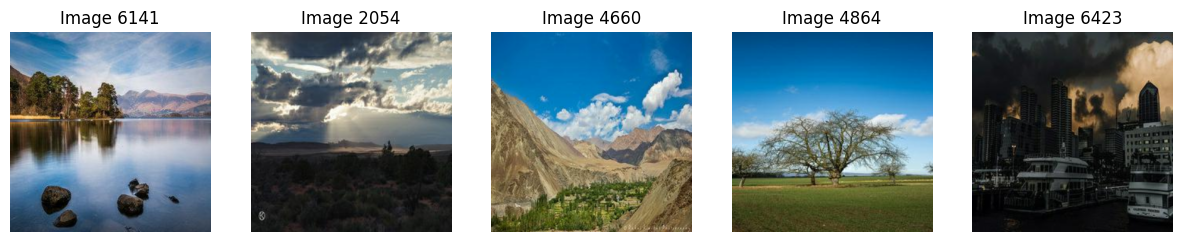

In [53]:
plot_random_images(image_list)

In [54]:
plot_random_images(monet_image_list)

In [55]:
def split_and_resize_quarters(original_image):
    # Convert PIL Image to NumPy array
    original_image_array = np.array(original_image)
    
    # Ensure the image is 320x320
    if original_image_array.shape[:2] != (320, 320):
        print("Error: Image size must be 320x320.")
        return None
    
    
    # Split the image into quarters
    quarters = []
    for i in range(2):
        for j in range(2):
            left = j * 160
            upper = i * 160
            right = left + 160
            lower = upper + 160
            quarter = original_image_array[upper:lower, left:right, :]
            quarters.append(quarter)
    
    # Resize each quarter to 320x320
    resized_quarters = [cv2.resize(quarter, (320, 320)) for quarter in quarters]
    
    return original_image , resized_quarters

In [56]:
original_image, quarters = split_and_resize_quarters(monet_image_list[0])
if quarters:
    # Plot original image and each quarter
    fig, axes = plt.subplots(3, 2, figsize=(10, 15))
    
    # Plot original image
    axes[0, 0].imshow(original_image)  # Convert BGR to RGB
    axes[0, 0].axis('off')
    axes[0, 0].set_title("Original Image")
    
    # Plot each quarter
    for i, quarter in enumerate(quarters):
        axes[(i+1)//2, (i+1)%2].imshow(quarter)  # Convert BGR to RGB
        axes[(i+1)//2, (i+1)%2].axis('off')
        axes[(i+1)//2, (i+1)%2].set_title(f"Quarter {i+1}")
    
    plt.show()

In [57]:
def get_images_with_high_color_variance(images, threshold):
    high_color_var_images = []
    
    for image in images:
        # Convert image to numpy array
        image_array = np.array(image)
        
        # Calculate color variance
        color_variance = np.var(image_array)
        # Check if color variance is higher than the threshold
        if color_variance > threshold:
            high_color_var_images.append(image)
    
    return high_color_var_images

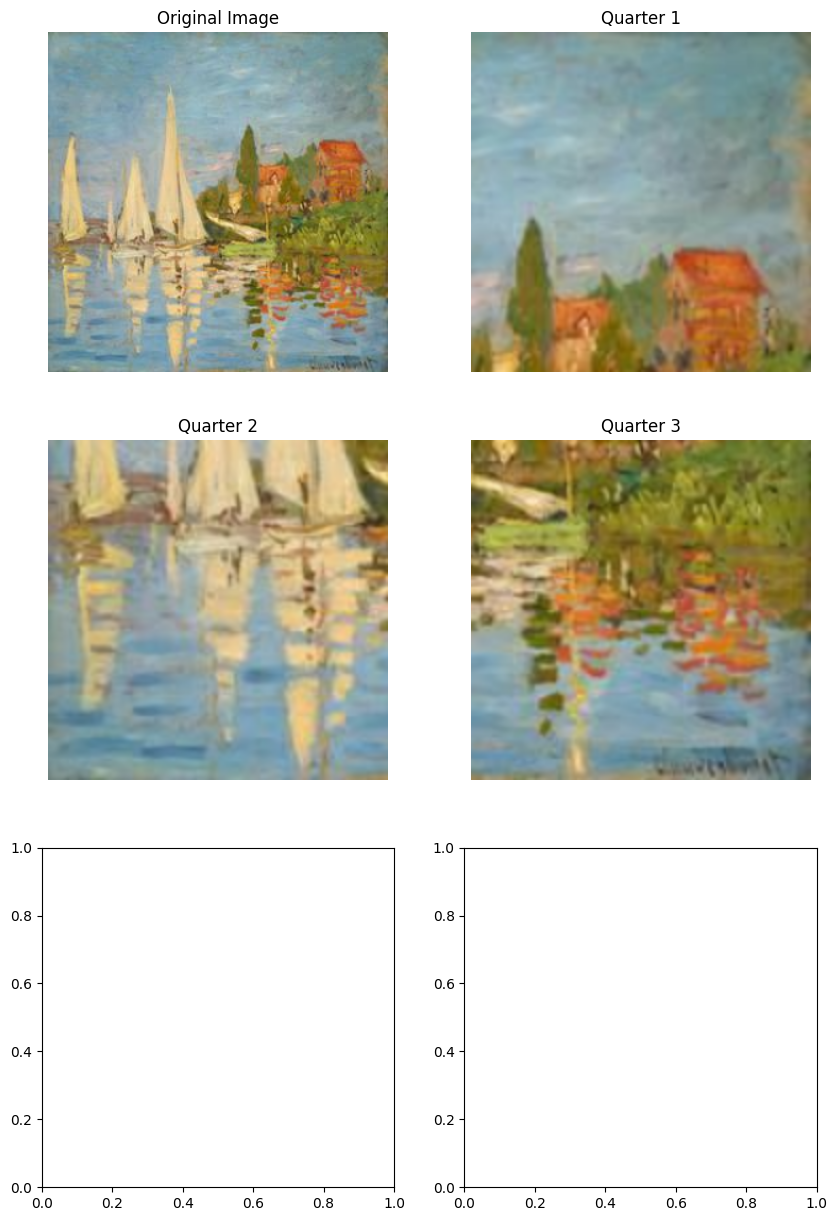

In [58]:
most_colorful_image = get_images_with_high_color_variance(quarters , 1000)
if most_colorful_image:
    # Plot original image and each quarter
    fig, axes = plt.subplots(3, 2, figsize=(10, 15))
    
    # Plot original image
    axes[0, 0].imshow(original_image)  # Convert BGR to RGB
    axes[0, 0].axis('off')
    axes[0, 0].set_title("Original Image")
    
    # Plot each quarter
    for i, quarter in enumerate(most_colorful_image):
        axes[(i+1)//2, (i+1)%2].imshow(quarter)  # Convert BGR to RGB
        axes[(i+1)//2, (i+1)%2].axis('off')
        axes[(i+1)//2, (i+1)%2].set_title(f"Quarter {i+1}")
    
    plt.show()

In [59]:
def mirror_flip(image):
    # Mirror flip the image horizontally
    flipped_image = cv2.flip(image, 1)
    return flipped_image


def aug_pipeline(images, threshold):
    augmented_images = []
    
    for image in images:
        # Split into quarters
        _ , quarters = split_and_resize_quarters(image)
        
        # Save only important quarters
        important_quarters = get_images_with_high_color_variance(quarters, threshold)

        # Mirror flip the original image
        mirrored_image = mirror_flip(image)
                
        # Combine original image, mirrored image, and important quarters
        augmented_images.append(image)
        augmented_images.append(mirrored_image)
        if len(important_quarters) != 0:
            augmented_images.extend(important_quarters)
    
    return augmented_images

1559


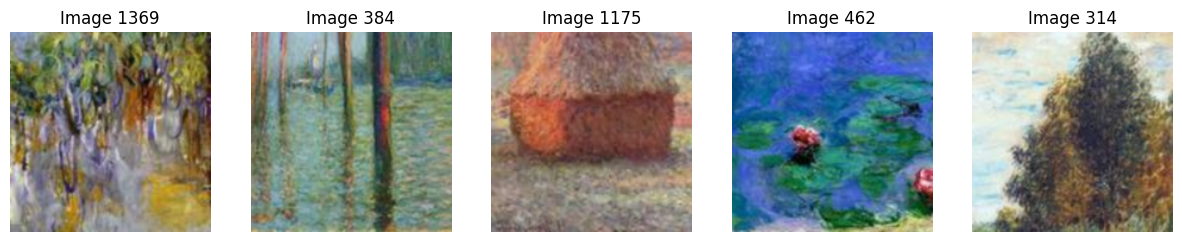

In [60]:
augmented_images = aug_pipeline(monet_image_list, 1000)
print(len(augmented_images))
plot_random_images(augmented_images)

In [61]:
# Define batch size
batch_size = 10

# Convert lists to TensorFlow datasets
monet_dataset = tf.data.Dataset.from_tensor_slices(augmented_images)
photo_dataset = tf.data.Dataset.from_tensor_slices(image_list)

# Zip the datasets to combine them
combined_dataset = tf.data.Dataset.zip((monet_dataset, photo_dataset))

# Optionally shuffle and batch the dataset
combined_dataset = combined_dataset.shuffle(buffer_size=len(augmented_images)).batch(batch_size)



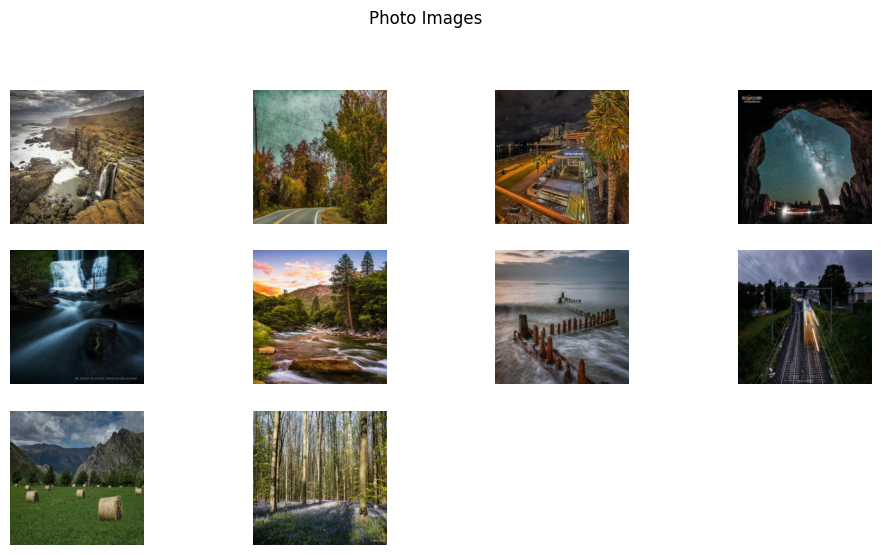

In [70]:
import matplotlib.pyplot as plt

def plot_images_from_batch(dataset, title):
    # Get one batch of images from the dataset
    images_batch = next(iter(dataset.batch(10)))  # Assuming batch size of 16
    # Create a figure with a larger size
    plt.figure(figsize=(12, 8))
    # Plot each image in the batch
    for i, image in enumerate(images_batch):
        plt.subplot(4, 4, i + 1)
        plt.imshow(image.numpy().astype("uint8"))  # Convert to uint8 for plotting
        plt.axis("off")
    # Set title and show plot
    plt.suptitle(title)
    plt.show()

# Plot one batch of Monet images
plot_images_from_batch(monet_dataset, "Monet Images")

# Plot one batch of photo images
plot_images_from_batch(photo_dataset, "Photo Images")


In [72]:

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result


sample = next(iter(monet_dataset.batch(1)))  # Assuming batch size of 1
sample_float32 = tf.cast(sample, tf.float32)

down_model = downsample(3, 4)
down_result = down_model(sample_float32)
print(down_result.shape)

(1, 160, 160, 3)


In [73]:

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result
     


up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 320, 320, 3)


In [74]:


# Define Generator model
def Generator():
  inputs = tf.keras.layers.Input(shape=[320, 320, 3])
  
  down_stack = [
    downsample(80, 4, apply_batchnorm=False),  # (batch_size, 160, 160, 80)
    downsample(160, 4),  # (batch_size, 64, 64, 128)
    downsample(320, 4),  # (batch_size, 32, 32, 256)
    downsample(640, 4),  # (batch_size, 16, 16, 512)
    downsample(640, 4),  # (batch_size, 8, 8, 512)
    downsample(640, 4),  # (batch_size, 4, 4, 512)
    # downsample(640, 4),  # (batch_size, 2, 2, 512)
    # downsample(640, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    # upsample(640, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    # upsample(640, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(640, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(640, 4 ,apply_dropout=True),  # (batch_size, 16, 16, 1024)
    upsample(320, 4),  # (batch_size, 32, 32, 512)
    upsample(160, 4),  # (batch_size, 64, 64, 256)
    upsample(80, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(3, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)



  x = inputs


  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)
     


  return tf.keras.Model(inputs=inputs, outputs=x)

# Test the generator model with random input batch
def test_build_generator():


    # Build generator model
    generator = Generator()
    

    input_shape = (320, 320, 3)  # Example input shape
    # Generate a random batch of input images
    batch_size = 4
    random_input_batch = tf.random.uniform((batch_size,) + input_shape, minval=0, maxval=1)
    
    # Forward pass through the generator
    generated_images = generator(random_input_batch)
    print(generator.summary())

    # Check output shape
    output_shape = generated_images.shape
    expected_output_shape = (batch_size, 320, 320, 3)  # Output shape with batch dimension
    
    # Check if the output shape matches the expected output shape
    assert output_shape == expected_output_shape, "Output shape mismatch"
    print("Test passed!")

# Run the test
test_build_generator()

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_27 (InputLayer)       [(None, 320, 320, 3)]        0         []                            
                                                                                                  
 sequential_319 (Sequential  (None, 160, 160, 80)         3840      ['input_27[0][0]']            
 )                                                                                                
                                                                                                  
 sequential_320 (Sequential  (None, 80, 80, 160)          205440    ['sequential_319[0][0]']      
 )                                                                                                
                                                                                           

In [79]:
# Define Discriminator model
def Discriminator(input_nc = 3, ndf=64, n_layers=3):
    inputs = tf.keras.layers.Input(shape=(None, None, input_nc))
    x = inputs
    nf_mult_prev = 1

    # First convolutional layer
    x = tf.keras.layers.Conv2D(ndf, kernel_size=4, strides=2, padding='same')(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    nf_mult = 1
    # Middle convolutional layers
    for n in range(1, n_layers):
        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n, 8)
        x = tf.keras.layers.Conv2D(ndf * nf_mult, kernel_size=4, strides=2, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(0.2)(x)

    # Last convolutional layer
    nf_mult_prev = nf_mult
    nf_mult = min(2 ** n_layers, 8)
    x = tf.keras.layers.Conv2D(ndf * nf_mult, kernel_size=4, strides=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    # Output convolutional layer
    outputs = tf.keras.layers.Conv2D(1, kernel_size=4, strides=1, padding='same')(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

# Test the discriminator model with random input batch
def test_build_discriminator():
    # Define input shape
    input_shape = (320, 320, 3)  # Example input shape

    # Build discriminator model
    discriminator = Discriminator(3)
    
    # Generate a random batch of input images
    batch_size = 4
    random_input_batch = tf.random.uniform((batch_size,) + input_shape, minval=0, maxval=1)
    
    # Forward pass through the discriminator
    discriminator_output = discriminator(random_input_batch)
    
    # Check output shape
    output_shape = discriminator_output.shape
    print(output_shape)
    print(discriminator.summary())
    expected_output_shape = (batch_size, 40, 40, 1)  # Output shape with batch dimension
    
    # Check if the output shape matches the expected output shape
    assert output_shape == expected_output_shape, "Output shape mismatch"
    print("Test passed!")

# Run the test
test_build_discriminator()

(4, 40, 40, 1)
Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 conv2d_235 (Conv2D)         (None, None, None, 64)    3136      
                                                                 
 leaky_re_lu_227 (LeakyReLU  (None, None, None, 64)    0         
 )                                                               
                                                                 
 conv2d_236 (Conv2D)         (None, None, None, 128)   131200    
                                                                 
 batch_normalization_353 (B  (None, None, None, 128)   512       
 atchNormalization)                                              
                                                                 
 leaky_re_lu_228 (LeakyReLU  (None, None, N

In [76]:

# Define adversarial loss
def adversarial_loss(y_true, y_pred):
    return tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)

In [90]:
def cycle_consistency_loss(real_images, generated_images):
    print(real_images.shape, generated_images.shape)
    # Calculate absolute difference between real and generated images
    abs_diff = tf.abs(real_images - generated_images)
    # Compute mean across all axes except the batch axis
    loss = tf.reduce_mean(abs_diff, axis=[1, 2, 3])
    # Compute mean loss across the batch
    mean_loss = tf.reduce_mean(loss)
    return mean_loss

In [80]:

# Build and compile the generators
generator_G = Generator()
generator_F = Generator()
generator_G.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss=adversarial_loss)
generator_F.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss=adversarial_loss)

# Build and compile the discriminators
discriminator_X = Discriminator()
discriminator_Y = Discriminator()
discriminator_X.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss=adversarial_loss)
discriminator_Y.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss=adversarial_loss)


In [81]:
def train_one_batch(generator_G, generator_F, discriminator_X, discriminator_Y, batch_X, batch_Y):
    # Train generator G
    with tf.GradientTape() as gen_G_tape, tf.GradientTape() as gen_F_tape:
        # Generate fake images
        fake_Y = generator_G(batch_X, training=True)
        fake_X = generator_F(batch_Y, training=True)
        
        # Generate reconstructed images
        reconstr_X = generator_F(fake_Y, training=True)
        reconstr_Y = generator_G(fake_X, training=True)
        
        # Identity mapping loss
        identity_loss_X = cycle_consistency_loss(batch_X, reconstr_X)
        identity_loss_Y = cycle_consistency_loss(batch_Y, reconstr_Y)
        
        # Adversarial loss
        adv_loss_G = adversarial_loss(tf.ones_like(discriminator_Y(fake_Y)), discriminator_Y(fake_Y))
        adv_loss_F = adversarial_loss(tf.ones_like(discriminator_X(fake_X)), discriminator_X(fake_X))
        
        # Cycle consistency loss
        cycle_loss = identity_loss_X + identity_loss_Y
        
        # Total generator loss
        total_gen_G_loss = adv_loss_G + cycle_loss
        total_gen_F_loss = adv_loss_F + cycle_loss
        
    # Compute gradients of generator loss with respect to generator variables
    gen_G_gradients = gen_G_tape.gradient(total_gen_G_loss, generator_G.trainable_variables)
    gen_F_gradients = gen_F_tape.gradient(total_gen_F_loss, generator_F.trainable_variables)
    
    # Apply gradients to generator variables
    generator_G.optimizer.apply_gradients(zip(gen_G_gradients, generator_G.trainable_variables))
    generator_F.optimizer.apply_gradients(zip(gen_F_gradients, generator_F.trainable_variables))
    
    # Train discriminator X
    with tf.GradientTape() as disc_X_tape:
        disc_X_real_output = discriminator_X(batch_X, training=True)
        disc_X_fake_output = discriminator_X(fake_X, training=True)
        
        # Compute discriminator X loss
        disc_X_loss = adversarial_loss(tf.ones_like(disc_X_real_output), disc_X_real_output) + \
                      adversarial_loss(tf.zeros_like(disc_X_fake_output), disc_X_fake_output)
    
    # Compute gradients of discriminator X loss with respect to discriminator X variables
    disc_X_gradients = disc_X_tape.gradient(disc_X_loss, discriminator_X.trainable_variables)
    
    # Apply gradients to discriminator X variables
    discriminator_X.optimizer.apply_gradients(zip(disc_X_gradients, discriminator_X.trainable_variables))
    
    # Train discriminator Y
    with tf.GradientTape() as disc_Y_tape:
        disc_Y_real_output = discriminator_Y(batch_Y, training=True)
        disc_Y_fake_output = discriminator_Y(fake_Y, training=True)
        
        # Compute discriminator Y loss
        disc_Y_loss = adversarial_loss(tf.ones_like(disc_Y_real_output), disc_Y_real_output) + \
                      adversarial_loss(tf.zeros_like(disc_Y_fake_output), disc_Y_fake_output)
    
    # Compute gradients of discriminator Y loss with respect to discriminator Y variables
    disc_Y_gradients = disc_Y_tape.gradient(disc_Y_loss, discriminator_Y.trainable_variables)
    
    # Apply gradients to discriminator Y variables
    discriminator_Y.optimizer.apply_gradients(zip(disc_Y_gradients, discriminator_Y.trainable_variables))


In [82]:
def train(generator_G, generator_F, discriminator_X, discriminator_Y, combined_dataset, epochs):
    num_batches = len(combined_dataset)
    
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        
        # Use tqdm to create a progress bar for the batches
        progress_bar = tqdm(combined_dataset, total=num_batches, desc=f"Epoch {epoch + 1}/{epochs}")
        
        for batch_X, batch_Y in progress_bar:
            train_one_batch(generator_G, generator_F, discriminator_X, discriminator_Y, batch_X, batch_Y)
        



In [83]:

# Build and compile the generators
generator_G = Generator()
generator_F = Generator()
generator_G.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss=adversarial_loss)
generator_F.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss=adversarial_loss)

# Build and compile the discriminators
discriminator_X = Discriminator()
discriminator_Y = Discriminator()
discriminator_X.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss=adversarial_loss)
discriminator_Y.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss=adversarial_loss)

In [91]:
train(generator_G, generator_F, discriminator_X, discriminator_Y, combined_dataset, epochs=10)


Epoch 1/10


Epoch 1/10:   0%|          | 0/156 [00:06<?, ?it/s]

(10, 320, 320, 3) (10, 320, 320, 3)


InvalidArgumentError: cannot compute Sub as input #1(zero-based) was expected to be a uint8 tensor but is a float tensor [Op:Sub] name: 